# **<center>ML Models on Mathematics Learning</center>**

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('MathE_dataset.csv', delimiter=';', encoding='latin1')

### **Setup**

In [124]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer, LabelEncoder, OrdinalEncoder
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from keras.optimizers import Adam

from tensorflow import keras
from tensorflow.keras import layers, backend as K
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import warnings
warnings.filterwarnings('ignore')

### **Preprocessing and Splitting**

In [130]:
# Define features and target variables
features = ['Student Country', 'Question Level', 'Topic', 'Subtopic', 'Keywords']
target = ['Type of Answer']

X = df[features]
y = df[target]

In [ ]:
# encoding and scaling
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False), ['Student Country', 'Topic', 'Question Level']),
    ('ordinal', OrdinalEncoder(), ['Subtopic', 'Keywords'])
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())
])

# pipeline.fit(X)
X_enc = pipeline.fit_transform(X)

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
X_enc = pd.DataFrame(X_enc, columns=feature_names)
X_enc.head(2)

,onehot__Student Country_Italy,onehot__Student Country_Lithuania,onehot__Student Country_Portugal,onehot__Student Country_Romania,onehot__Student Country_Russian Federation,onehot__Student Country_Slovenia,onehot__Student Country_Spain,onehot__Topic_Complex Numbers,onehot__Topic_Differential Equations,onehot__Topic_Differentiation,...,onehot__Topic_Linear Algebra,onehot__Topic_Numerical Methods,onehot__Topic_Optimization,onehot__Topic_Probability,onehot__Topic_Real Functions of a single variable,onehot__Topic_Set Theory,onehot__Topic_Statistics,onehot__Question Level_Basic,ordinal__Subtopic,ordinal__Keywords
0,-0.40725,-0.421998,-1.164670,-0.079531,-0.10647,-0.293059,-0.054238,-0.25713,-0.106972,-0.254106,...,-1.224317,-0.183206,-0.139414,-0.11658,-0.132213,-0.066477,5.203506,0.465812,0.939661,1.239861
1,-0.40725,-0.421998,0.858613,-0.079531,-0.10647,-0.293059,-0.054238,-0.25713,-0.106972,-0.254106,...,-1.224317,-0.183206,-0.139414,-0.11658,-0.132213,-0.066477,5.203506,0.465812,0.939661,1.239861


In [143]:
# split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, stratify=y, random_state=42)

### **Neural Networks**

In [ ]:
# Build the model
def build_model():
    model = keras.Sequential([
        layers.Dense(16, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001), 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    return model

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor = 'loss',
    patience = 10,
    restore_best_weights = True
)

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


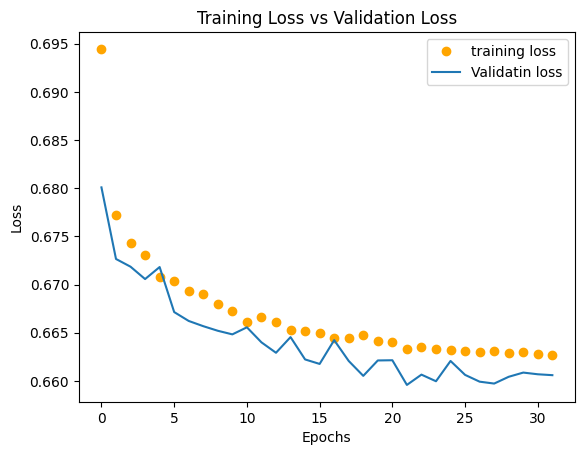

In [161]:
# fit the model
model = build_model()

history = model.fit(
    X_train, y_train,
    epochs = 32,
    batch_size = 32,
    verbose = 0,
    validation_data = (X_test, y_test)
)

history_dict = history.history
print(history_dict.keys())

plt.plot(history_dict['loss'], 'bo', label='training loss', color='orange')
plt.plot(history_dict['val_loss'], label='Validatin loss')

plt.legend()
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

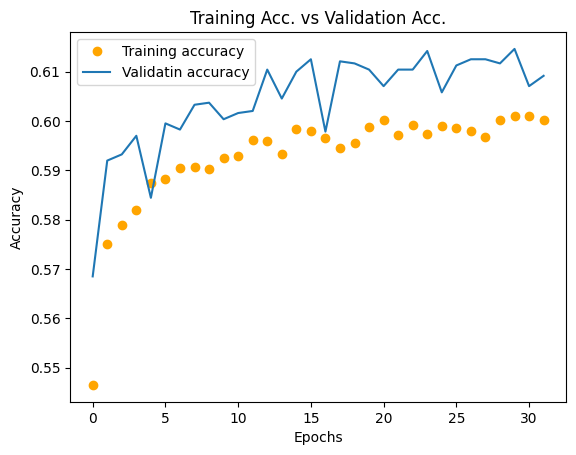

In [162]:
plt.plot(history_dict['accuracy'], 'bo', label='Training accuracy', color='orange')
plt.plot(history_dict['val_accuracy'], label='Validatin accuracy')

plt.legend()
plt.title('Training Acc. vs Validation Acc.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [163]:
k = 4
x_shape = X_train.shape
num_val_samples = x_shape[0] // k
num_epochs = 100
batch = 10
all_scores = []

# shuffle the data
X_enc, y = shuffle(X_enc, y)

model = build_model()

for i in range(k):
    print(f"Processing fold {i}")
    # set aside validation data for ith fold
    val_input = X_enc[i * num_val_samples: (i+1) * num_val_samples]
    val_target = y[i * num_val_samples: (i+1) * num_val_samples]

    # actual training data
    partial_x_train = np.concatenate([
        X_enc[: i * num_val_samples],
        X_enc[(i+1) * num_val_samples:]
    ], axis=0)
    
    partial_y_train = np.concatenate([
        y[: i * num_val_samples],
        y[(i+1) * num_val_samples:]
    ], axis = 0)

    # fit the model
    model.fit(
        partial_x_train, partial_y_train,
        epochs = num_epochs, batch_size = batch, verbose = 0,
        callbacks = [early_stop]
    )

    # evaluate the model on the validation data set
    loss_val, acc_val = model.evaluate(val_input, val_target, verbose=0)
    all_scores.append(acc_val)

    # clear session
    K.clear_session()

print("Mean score: ", np.mean(all_scores))

Processing fold 0
Processing fold 1
Processing fold 2
Processing fold 3
Mean score:  0.6046731024980545


### **Sklearn Models**

> k-fold Appproach

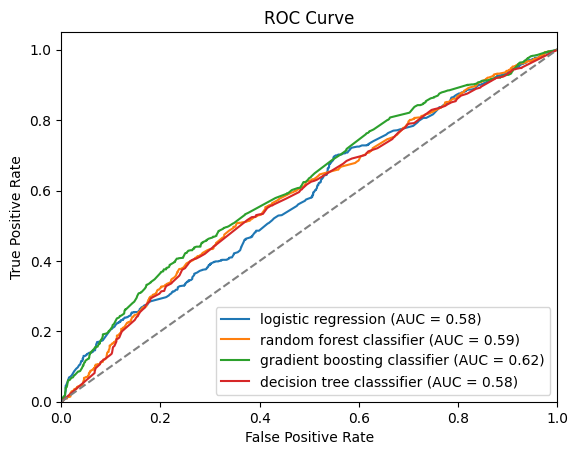

In [166]:
models = {
    'logistic regression': LogisticRegression(),
    'random forest classifier': RandomForestClassifier(),
    'gradient boosting classifier': GradientBoostingClassifier(),
    'decision tree classsifier': DecisionTreeClassifier()
}

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=0)
results = {name: {'f1 scores': [], 'roc_auc scores': []} for name in models}
X_np = X_enc.to_numpy()
y_np = y.to_numpy()

for model_name, model in models.items():
    fpr_list, tpr_list, roc_auc_list = [], [], []
    for train_idx, test_idx in kf.split(X_np):
        # for kth fold, split the data into training and test data
        X_ktrain, X_ktest = X_np[train_idx], X_np[test_idx]
        y_ktrain, y_ktest = y_np[train_idx], y_np[test_idx]

        # Fit the model
        model.fit(X_ktrain, y_ktrain)

        # predictions on the test data
        y_pred = model.predict(X_ktest)
        y_proba = model.predict_proba(X_ktest)[:,1] if hasattr(model, 'predict_proba') else None

        # evaluate the model's performance
        f1 = f1_score(y_ktest, y_pred)
        results[model_name]['f1 scores'].append(f1)

        if y_proba is not None:
            roc_score = roc_auc_score(y_ktest, y_proba) if y_proba is not None else None
            results[model_name]['roc_auc scores'].append(roc_score)
            fpr, tpr, thresholds = roc_curve(y_ktest, y_proba)
            fpr_list.append(fpr)
            tpr_list.append(tpr)
            roc_auc = auc(fpr, tpr)
            roc_auc_list.append(roc_auc)
        else: None

    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fpr_list, tpr_list)], axis=0)
    avg_roc_auc = np.mean(roc_auc_list)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    
# Plot formatting
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
    

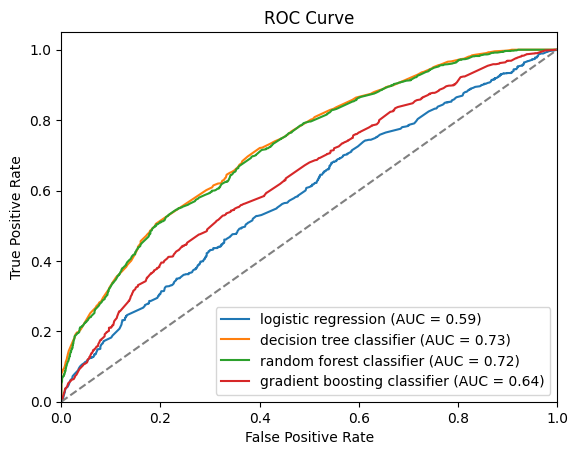

In [ ]:
# Define models to fit
models = {
    "logistic regression": LogisticRegression(),
    "decision tree classifier": DecisionTreeClassifier(),
    "random forest classifier": RandomForestClassifier(),
    "gradient boosting classifier": GradientBoostingClassifier()
}

results = {name: {'f1 scores': [], 'roc_auc scores': []} for name in models}

for model_name, model in models.items():
    # fit the model
    model.fit(X_train, y_train)

    # predict the target on the test data
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # evaluate the models' performance
    f1 = f1_score(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    # Append scores
    results[model_name]['f1 scores'].append(f1)
    if auroc is not None:
        results[model_name]['roc_auc scores'].append(auroc)

    if y_proba is not None:
        # Calculate the ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        
        # Calculate the AUC
        roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Plot formatting
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [169]:
pd.DataFrame(results)

,logistic regression,decision tree classifier,random forest classifier,gradient boosting classifier
f1 scores,[0.3504492939666239],[0.5932721712538226],[0.6050172159370388],[0.4706546275395034]
roc_auc scores,[0.5902701125363174],[0.7288037571313177],[0.7245827641671284],[0.6381318802150073]
